# Tutorial: How to identify bias in hate speech detection

In this notebook you will see how to test a model with our Biaslyze tool in order to inspect it on hints for possible bias. Biaslyze uses counterfactual token fairness scores to evaluate the significance of concepts and attributes sensible to discrimination within the models decisions. 
To show you how Biaslyze works we use data from a Kaggle challenge and build a model that classifies texts from online comments as toxic or not toxic. 
The data consists of instances of 226235 online comments. You can get the data on the kaggle site.

Data source: [https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

# Installation
First install the Biaslyze python package using:

In [ ]:
!pip install biaslyze

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

## Load and prepare data

In [4]:
df = pd.read_csv("../data/jigsaw-toxic-comment-classification/train.csv"); df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Now make the classification problem binary: 
Apart from the descriptive multi-label toxicity labels, there is another target column with a binary class signifying if a comment text is toxic or non-toxic.

In [5]:
df["target"] = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].sum(axis=1) > 0

## Train a BoW-model

In [6]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=30000, stop_words="english"), LogisticRegression(C=10))

In [7]:
clf.fit(df.comment_text, df.target)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression(C=10))])

## Counterfactual token based bias detection

Now that we have a model to test, lets evaluate it with the Biaslyze tool and test the sensible concepts for possible bias. 
Biaslyze takes keywords representing sensitive concepts and perturbates them with the other keywords from the same concept to evaluate its significance for the models prediction.

In [8]:
from biaslyze.bias_detectors import LimeBiasDetector, CounterfactualBiasDetector

In [9]:
bias_detector = CounterfactualBiasDetector()

In [10]:
counterfactual_detection_results = bias_detector.process(
    texts=df.comment_text.sample(10000, random_state=42),
    labels=df.target.tolist(),
    predict_func=clf.predict_proba,
    concepts_to_consider=["religion", "gender"],
    max_counterfactual_samples=None,
)

2023-05-26 17:12:14.547 | INFO     | biaslyze.concept_detectors:detect:35 - Started keyword-based concept detection on 10000 texts...
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4097.15it/s]
2023-05-26 17:12:16.995 | INFO     | biaslyze.concept_detectors:detect:51 - Done. Found 8997 texts with protected concepts.
2023-05-26 17:12:16.996 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:process:116 - Processing concept religion...
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8997/8997 [00:58<00:00, 152.90it/s]
2023-05-26 17:13:15.845 | INFO     | biaslyze.bias_detectors.counterfactual_biasdetector:_extract_counterfactual_concept_samples:219 - Extracted 6118 counterfactual sampl

### Not every Keyword has an effect. 
You can get a list like below showing you the keywords of a concept that have no effect or are not in the vocabulary of the model. In this case the list refers to "gender". Reviewing the omitted keywords gives you an idea of a concepts scope and the sample composition.

In [11]:
print(counterfactual_detection_results.concept_results[1].omitted_keywords)

['hers', 'herself', 'grandmothers', 'grandmas', 'sista', 'sistas', 'him', 'his', 'himself', 'daddies', 'grandfathers', 'grandpa', 'grandpas', 'them', 'themselves']


# Lets look at some results

## Counterfactual Score
The first plot below shows you the top 10 keywords found within the concept "gender" according to the difference resulting from the replacement of counterfactuals with that keyword. 
The counterfactual score is defined as the difference between the predicted probability score for the counterfactual text and  the predicted probability score for the original text.
    
> counterfactual_score = P(toxic | counterfactual_text) - P(toxic | original_text)

Therefore the further a samples score is from zero, the greater the change in the model's decision whether a comment is toxic or non-toxic when it is replaced by that keyword. In this case the positive class is "toxic" and the negative class is "non-toxic". As you can see replacing any other gender keyword with the word "mum" makes the samples classification more likely to be "toxic".

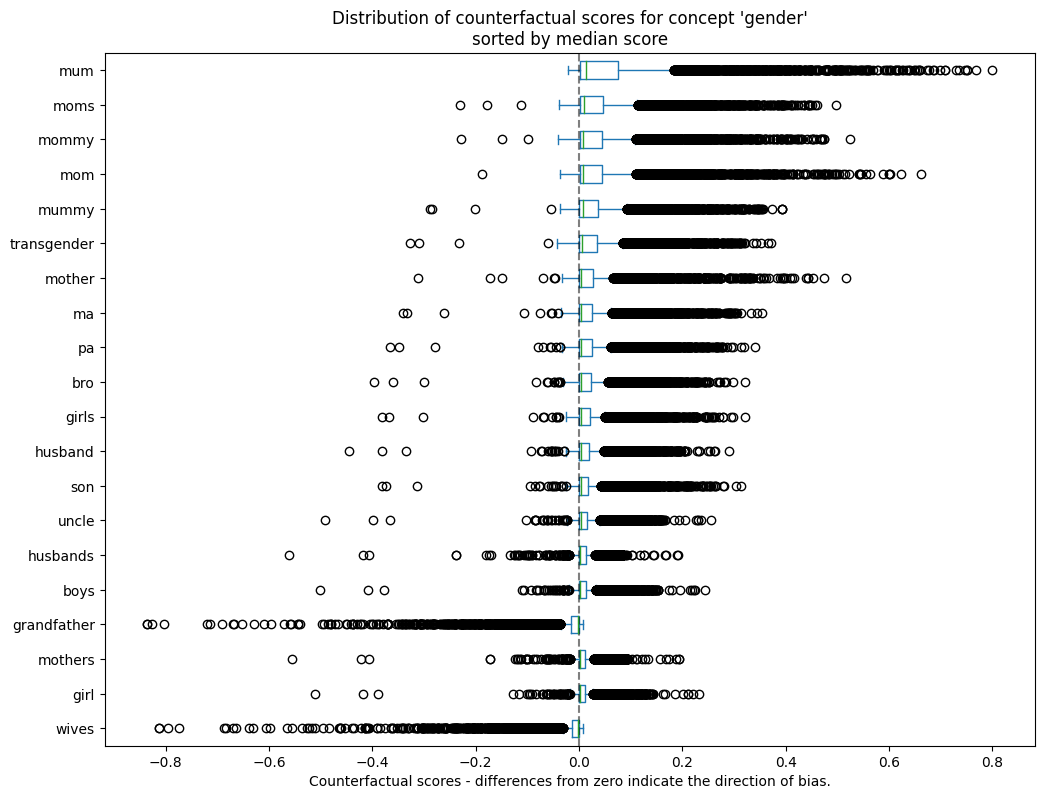

In [12]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="gender", top_n=20)

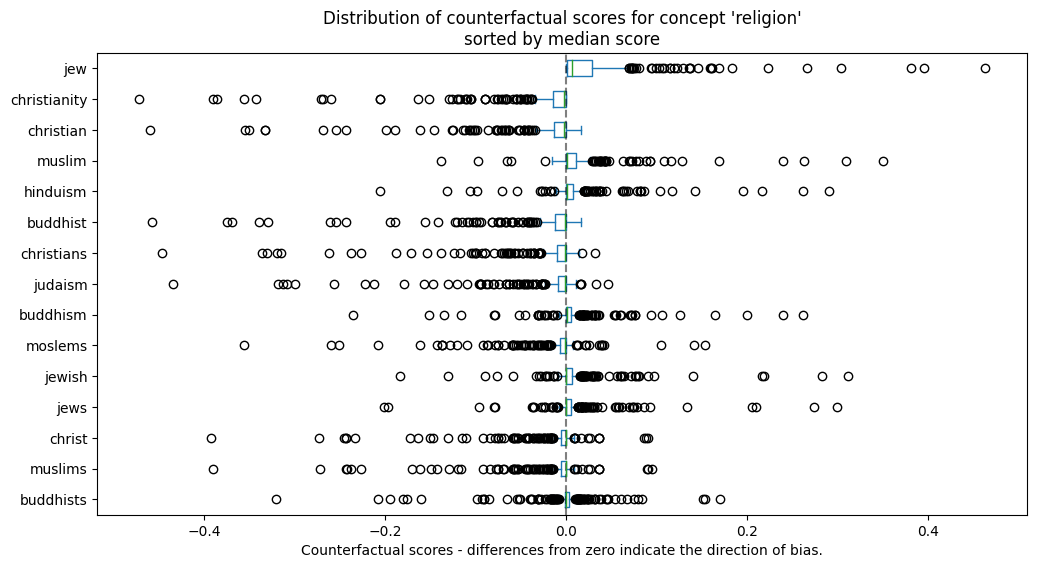

In [13]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="religion", top_n=15)

## Key-sample replacement score (ksr-score)
This score looks at how the toxicity-probability changes for all samples with a certain keyword (y-axis) when it is replaced by the counterfactuals from its corresponding concept. This gives you a better look at the representation of a certain keyword within the samples. Once again looking at the keyword "mum" we can see that when it is replaced by counterfactuals the model will less likely predict the sample comment to be toxic.
Seeing that many keywords representing females have a strong impact on the models toxicity-prediction we can now ask whether the model might be biased in this way and look into it further, potentially mitigating at some point.


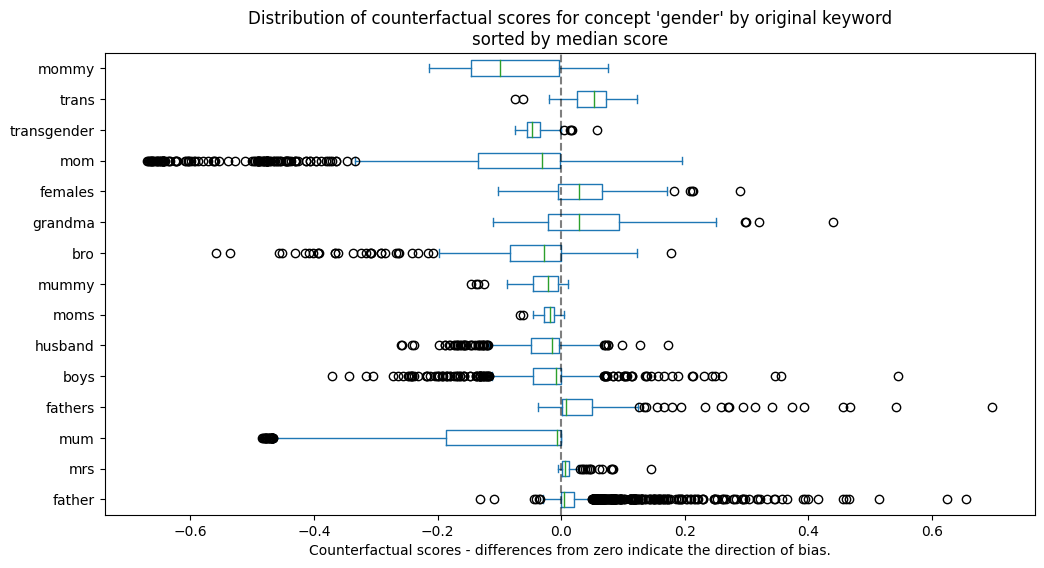

In [14]:
counterfactual_detection_results.visualize_counterfactual_sample_scores(concept="gender", top_n=15)

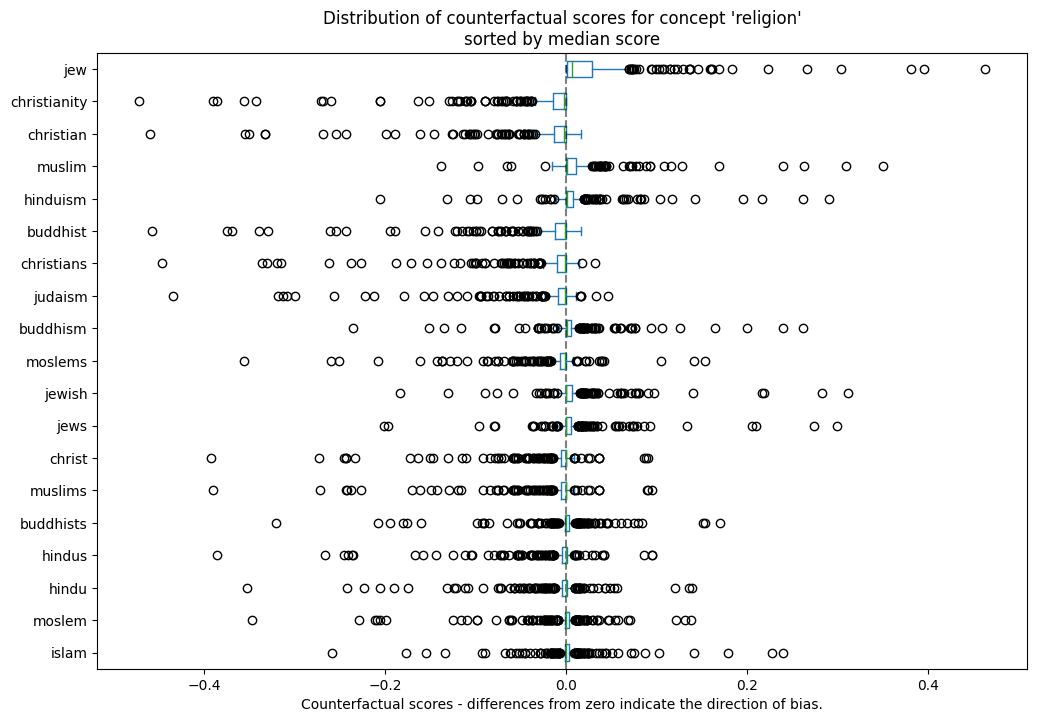

In [15]:
counterfactual_detection_results.visualize_counterfactual_scores(concept="religion", top_n=20)

## Looking into the samples
The next plot shows you the samples from concept "gender" with the bubble size representing the ksr-score. The color blue indicates a positive (likely toxic) score for a certain keyword and orange is a negative (less likely to be toxic) score of a keyword compared to the counterfactuals. Use it to review the samples content.

In [16]:
from bokeh.io import show, output_notebook

output_notebook()

Loading BokehJS ...

In [17]:
viz = counterfactual_detection_results.visualize_counterfactual_score_by_sample(concept="gender")

show(viz)

/home/tobias/.cache/pypoetry/virtualenvs/biaslyze-OjqpgMw8-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 188/188 [05:45<00:00,  1.84s/it]
